In [2]:
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from rich.progress import track
from rich import progress
import IPython
import pandas as pd
import numpy.typing as npt
import pickle
from centrex_trajectories import (
    Coordinates,
    Gravity,
    PropagationType,
    Velocities,
    Force,
    propagate_trajectories,
    PropagationOptions,
)
from centrex_trajectories.particles import TlF
from centrex_trajectories.beamline_objects import (
    CircularAperture,
    ElectrostaticQuadrupoleLens,
    RectangularAperture,
    Section,
    Bore,
    PlateElectrodes,
)
from centrex_trajectories.visualization import plot_beamline
plt.rcParams.update({"font.size": 14})
class TaskSpeed(progress.ProgressColumn):
    def render(self, task):
        if task.speed is None:
            return ""
        elif task.speed >= 0.1:
            return f"{( task.speed or 0 ):.1f}/s"
        else:
            return f"{( 1 / task.speed or 0):.1f} s/i"
n_trajectories = 10_000_000
options = PropagationOptions(verbose=False, n_cores=24)
gravity = Gravity(0, -9.81, 0)
particle = TlF()

# EQL parameters
L = 0.6
R = 1.75 * 25.4e-3 / 2
V = 28_000


# DET parameters
wx_det = 13e-3
wy_det = 3e-3

# conversion factors
in_to_m = 25.4e-3

n_nipples = 2

# beamline lengths
distance_lens_bbexit = 36 * in_to_m
lens_chamber_length = (24 + 5 / 8) * in_to_m
lens_reducer_flange = (7 / 8 + 3 + 1 / 8) * in_to_m
lens_electrode_length = 0.6  # m
nipple_length = 39 * in_to_m
distance_det_center = 5.25 * in_to_m
lens_flange_with_oring = 7 / 8 * in_to_m
bs_flange = 3 / 4 * in_to_m
rc_chamber_length_no_flanges = 10.5 * in_to_m
rc_chamber_center_from_bs_front = (16 + 3 / 8) * in_to_m
rc_aperture_from_center = 3.56 * in_to_m
rc_aperture_width = 8e-3
rc_aperture_height = 6e-3
lens_chamber_to_electrode = (30 + 19 + 1/4) * in_to_m
fourK = Section(
    name="4K shield",
    objects=[CircularAperture(0, 0, 1.75 * in_to_m, in_to_m / 2)],
    start=0,
    stop=(1.75 + 0.25) * 0.0254,
    save_collisions=False,
		save_collision_trajectories=False,
    propagation_type=PropagationType.ballistic,
)
fourtyK = Section(
    name="40K shield",
    objects=[CircularAperture(0, 0, fourK.stop + 1.25 * in_to_m, in_to_m / 2)],
    start=fourK.stop,
    stop=fourK.stop + (1.25 + 0.25) * 0.0254,
    save_collisions=False,
		save_collision_trajectories=False,
    propagation_type=PropagationType.ballistic,
)
bbexit = Section(
    name="Beamsource Exit",
    objects=[CircularAperture(0, 0, fourtyK.stop + 2.5 * in_to_m, 2 * in_to_m)],
    start=fourtyK.stop,
    stop=fourtyK.stop + (2.5 + 0.75) * in_to_m,
    save_collisions=False,
		save_collision_trajectories=False,
    propagation_type=PropagationType.ballistic,
)


spa = Section(
    name="State Prep A",
    objects=[],
    start=bbexit.stop,
    stop=bbexit.stop + (19.6 + 0.375 + 9.625 + 0.375) * in_to_m,
    save_collisions=False,
		save_collision_trajectories=False,
    propagation_type=PropagationType.ballistic,
)

def scan_function(
    origin: Coordinates,
    velocities: Velocities,
    rc_radius: float,
    eql_voltage: float,
    distance_det: float,
    eql_length: float = 0.6,
    eql_radius: float = 0.022225,
    wx_det: float = 2e-2,
    wy_det: float = 1 * in_to_m,
    wx_int: float = 2e-2,
    wy_int: float = 3 * in_to_m,
    stark_potential: None | npt.NDArray[np.float64] = None,
):
    rc = Section(
        name="Rotational cooling",
        objects=[
            CircularAperture(
                x=0,
                y=0,
                z=bbexit.stop
                + rc_chamber_center_from_bs_front
                + rc_aperture_from_center,
                r=rc_radius,
            ),
        ],
        start=bbexit.stop
        + rc_chamber_center_from_bs_front
        + rc_aperture_from_center,
        stop=bbexit.stop
        + rc_chamber_center_from_bs_front
        + rc_chamber_length_no_flanges / 2,
        save_collisions=False,
		save_collision_trajectories=False,
        propagation_type=PropagationType.ballistic,
    )

    eql = ElectrostaticQuadrupoleLens(
        name="Electrostatic Lens",
        objects=[
            Bore(
                x=0,
                y=0,
                z=bbexit.stop
                + distance_lens_bbexit
                + (lens_chamber_length - lens_electrode_length) / 2,
                length=eql_length,
                radius=R,
            )
        ],
        start=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2,
        stop=bbexit.stop
        + distance_lens_bbexit
        + (lens_chamber_length - lens_electrode_length) / 2
        + eql_length,
        V=eql_voltage,
        R=eql_radius,
        save_collisions=False,
		save_collision_trajectories=False,
        stark_potential=stark_potential
    )

    pre_interaction_aperture = Section(
        name="Pre-Interaction Aperture",
        objects=[
            RectangularAperture(x=0, y=0, z=eql.stop + lens_flange_with_oring + lens_chamber_to_electrode + 0.0025, wx=wx_int, wy=wy_int)
        ],
        start=eql.stop + lens_flange_with_oring + lens_chamber_to_electrode,
        stop=eql.stop + lens_flange_with_oring + lens_chamber_to_electrode + 0.005,
        save_collisions=False,
		save_collision_trajectories=False,
        propagation_type=PropagationType.ballistic,
    )

    interaction = Section(
        name="Interaction",
        objects=[
            PlateElectrodes(
                x=0, y=0, z=pre_interaction_aperture.start, length=2.5, width=20e-2, separation=2e-2
            ),
        ],
        start=pre_interaction_aperture.start,
        stop=pre_interaction_aperture.start + 2.5,
		save_collision_trajectories=True,
        save_collisions=True,
        propagation_type=PropagationType.ballistic,
    )

    det = Section(
        name="Detection",
        objects=[
            RectangularAperture(
                0,
                0,
                eql.stop + distance_det,
                wx_det,
                wy_det,
            )
        ],
        start=eql.stop + distance_det - 1e-3,
        stop=eql.stop + distance_det + 1e-3,
        save_collisions=False,
		save_collision_trajectories=False,
        propagation_type=PropagationType.ballistic,
        force=None,
    )

    sections = [
        rc,
        spa,
        eql,
        pre_interaction_aperture,
        interaction,
        det,
    ]
    section_data, trajectories = propagate_trajectories(
        sections,
        origin,
        velocities,
        particle,
        force=gravity,
        options=options,
    )
    return section_data, trajectories, sections

In [3]:
import pickle

with open("rc_distribution.pkl", "rb") as f:
    trajectories_start = pickle.load(f)
origin = Coordinates(
    x=np.array([traj.x[-1] for traj in trajectories_start.values()]),
    y=np.array([traj.y[-1] for traj in trajectories_start.values()]),
    z=np.array([traj.z[-1] for traj in trajectories_start.values()]),
)
velocities = Velocities(
    vx=np.array([traj.vx[-1] for traj in trajectories_start.values()]),
    vy=np.array([traj.vy[-1] for traj in trajectories_start.values()]),
    vz=np.array([traj.vz[-1] for traj in trajectories_start.values()]),
)

In [12]:

sec_dat, trajectories, sections = scan_function(
    origin,
    velocities,
    rc_radius=10e-3,
    eql_voltage=16e3,
    distance_det=5.0,
    wx_int=19.5e-3,
)

9562


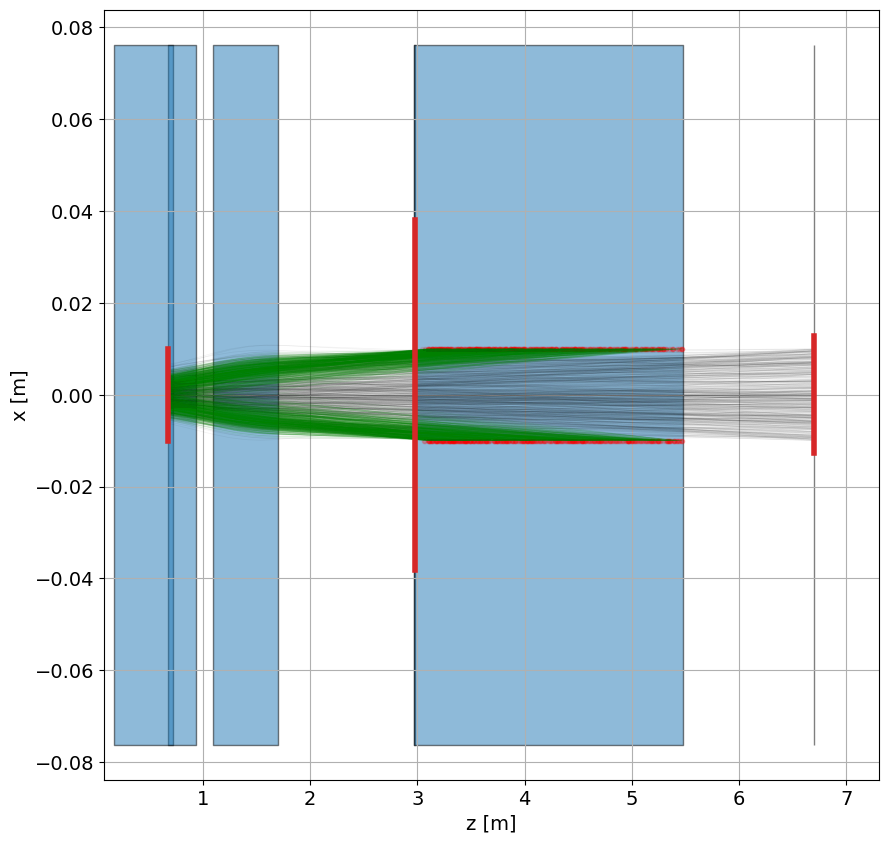

In [13]:

fig, ax = plt.subplots(figsize=(10,10))

idt = 0
for traj in trajectories.values():
    ax.plot(traj.z, traj.x, alpha=0.05, linewidth=0.5, color="k")
    idt += 1

    if idt == 20_000:
        break
for i in [4]:
    ax.plot(sec_dat[i].saved_collisions[0][0].z, sec_dat[i].saved_collisions[0][0].x, '.', color='red',  alpha=0.1)
for traj in sec_dat[4].saved_collision_trajectories.values():
    ax.plot(traj.z, traj.x, alpha=0.1, linewidth=0.5, color="g")
    idt += 1

    if idt == 20_000:
        break
plot_beamline(sections, ax=ax)

ax.set_xlabel("z [m]")
ax.set_ylabel("x [m]")

ax.grid(True)